In [1]:
import asmsa
import mdtraj as md
import nglview as nv
import numpy as np

2024-04-18 12:18:41.636279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 12:18:41.636301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 12:18:41.636941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 12:18:41.641335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 12:18:42.302481: W tensorflow/compiler/tf2

In [2]:
conf = "trpcage_correct.pdb"
topol = "topol_correct.top"
index = 'index_correct.ndx'
gro = 'trpcage_correct.gro'

In [3]:
# outputs of prepare.ipynb

#train_tr = md.load('x_train.xtc',top=conf)
#test_tr = md.load('x_test.xtc',top=conf)

train_tr = md.load('train.xtc',top=conf)
test_tr = md.load('test.xtc',top=conf)

In [4]:
train_g = np.moveaxis(train_tr.xyz,0,-1)
test_g = np.moveaxis(test_tr.xyz,0,-1)

In [5]:
train_g.shape

(144, 3, 36540)

In [6]:
sparse_dists = asmsa.NBDistancesSparse(train_g.shape[0], density=2)
mol = asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[sparse_dists])

In [7]:
train_int = mol.intcoord(train_g)
train_int.shape

(1419, 36540)

In [8]:
test_int = mol.intcoord(test_g)
test_int.shape

(1419, 7830)

In [9]:
# faking ... true output of decoder predicting something should come here

out_idx = 100

dec_out = test_int[:,out_idx]
dec_out.shape

(1419,)

In [10]:
diff = train_int.T - dec_out
msd = np.sum(diff * diff,axis=1)

In [11]:
minidx = np.argmin(msd)

In [12]:
train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32)
train_scale = np.loadtxt('datasets/intcoords/scale.txt',dtype=np.float32)

In [13]:
dec_out_scaled = dec_out * train_scale + train_mean

In [14]:
# see train.ipynb
grotr = md.load(gro)
nhs = grotr.topology.select('element != H')

with open(index) as f:
    f.readline()
    ndx = np.fromstring(" ".join(f),dtype=np.int32,sep=' ')-1

pdb2gmx = nhs[np.argsort(ndx)]+1


In [15]:
pdb2gmx

array([  1,   5,  13,  14,   7,  10,  11,  12,  15,  17,  23,  24,  19,
        25,  27,  44,  45,  29,  32,  33,  42,  35,  40,  37,  38,  46,
        48,  54,  55,  50,  56,  58,  71,  72,  60,  63,  66,  67,  68,
        73,  75,  95,  96,  77,  80,  81,  94,  83,  85,  92,  86,  90,
        88,  97,  99, 114, 115, 101, 104, 106, 110, 116, 118, 124, 125,
       120, 126, 128, 136, 137, 130, 133, 134, 135, 138, 140, 143, 144,
       145, 147, 150, 151, 152, 162, 164, 165, 159, 156, 153, 166, 168,
       175, 176, 170, 173, 177, 179, 186, 187, 181, 184, 188, 190, 193,
       194, 195, 197, 217, 218, 199, 202, 205, 208, 210, 211, 214, 219,
       229, 231, 232, 226, 223, 220, 233, 243, 245, 246, 240, 237, 234,
       247, 257, 259, 260, 254, 251, 248, 261, 263, 270, 272, 265, 268,
       271])

In [16]:
import gromacs as gmx

In [17]:
mintr = train_tr[minidx]
mintr.save('min.pdb')

In [18]:
ompthreads=2
mpiranks=1

In [ ]:
# Kubernetes deployment
mdrunner=gmx.MDrunnerK8s()

def mdrun(**kwargs):
    mdrunner.run(pre={'cores':ompthreads*mpiranks,'gpus':1}, mdrunargs={**kwargs,'ntomp':ompthreads,'pin':'on'},ncores=mpiranks)

In [19]:
# alternative local deployment
mdrunner=gmx.run.MDrunner()

# XXX: no MPI support so far
def mdrun(**kwargs):
    mdrunner.run(mdrunargs={**kwargs,'ntomp':ompthreads,'pin':'on'})

In [25]:
gmx.pdb2gmx(f='min.pdb',o='min.gro',p='min.top',water='tip3p',ff='amber94')


== CUDA ==

CUDA Version 12.3.1

Container image Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

A copy of this license is made available in this container at /NGC-DL-CONTAINER-LICENSE for your convenience.



            :-) GROMACS - gmx pdb2gmx, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /work
Command line:
  gmx pdb2gmx -f min.pdb -o min.gro -p min.top -water tip3p -ff amber94

Opening force field file /gromacs/AVX2_256_ts/share/gromacs/top/amber94.ff/aminoacids.r2b
Opening force field file /gromacs/AVX2_256_ts/share/gromacs/top/amber94.ff/dna.r2b
Opening force field file /gromacs/AVX2_256_ts/share/gromacs/top/amber94.ff/rna.r2b
All occupancies are one
Opening force field file /gromacs/AVX2_256_ts/share/gromacs/top/amber94.ff/atomtypes.atp
Opening force field file /gromacs/AVX2_256_ts/share/gromacs/top/amber94.ff/aminoacids.rtp
Opening force field file /gromacs/AVX2_256_ts/share/gromacs/top/amber94.ff/dna.rtp
Opening force field file /gromacs/AVX2_256_ts/share/gromacs/top/amber94.ff/rna.rtp
Opening force field file /gromacs/AVX2_256_ts/share/gromacs/top/amber94.ff/aminoacids.hdb
Opening force field file /groma

Using the Amber94 force field in directory amber94.ff

going to rename amber94.ff/aminoacids.r2b

going to rename amber94.ff/dna.r2b

going to rename amber94.ff/rna.r2b
Reading min.pdb...
Read '', 144 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 1 chains and 0 blocks of water and 20 residues with 144 atoms

  chain  #res #atoms

  1 'A'    20    144  

All occupancies are one

Reading residue database... (Amber94)

Processing chain 1 'A' (144 atoms, 20 residues)

Identified residue ASP1 as a starting terminus.

Identified residue SER20 as a ending terminus.

Checking for duplicate atoms....

Generating any missing hydrogen atoms and/or adding termini.

Now there are 20 residues with 272 atoms

Making bonds...

Number of bonds was 279, now 278

Generating angles, dihedrals and pairs...

Making cmap torsions...

There are  749 dihedrals,   60 impropers,  502 angles
           718 pairs,      278 bonds and     0 virtual sites

T

(0, None, None)

In [26]:
mdbox=2.0
gmx.editconf(f='min.gro',o="min-box.gro",c=True,d=str(mdbox),bt="dodecahedron")


== CUDA ==

CUDA Version 12.3.1

Container image Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

A copy of this license is made available in this container at /NGC-DL-CONTAINER-LICENSE for your convenience.



            :-) GROMACS - gmx editconf, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /work
Command line:
  gmx editconf -f min.gro -o min-box.gro -c -d 2.0 -bt dodecahedron


Back Off! I just backed up min-box.gro to ./#min-box.gro.2#

GROMACS reminds you: "The soul? There's nothing but chemistry here" (Breaking Bad)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 272 atoms
Volume: 51.9452 nm^3, corresponds to roughly 23300 electrons
No velocities found
    system size :  2.576  1.839  2.486 (nm)
    diameter    :  2.818               (nm)
    center      :  2.951  3.003  3.062 (nm)
    box vectors :  3.731  3.731  3.731 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  51.95               (nm^3)
    shift       :  2.162  2.110 -0.652 (nm)
new center      :  5.114  5.114  2.411 (nm)
new box vectors :  6.818  6.818  6.818 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 224.13               (nm^3)


(0, None, None)

In [27]:
!cp min.top restrained.top

off = mol.dihed4.shape[0]*2+mol.dihed9.shape[0]*2+mol.angles.shape[0]+mol.bonds.shape[0]

dec_dist = dec_out_scaled[off:]


with open('restrained.top','a') as t:
    t.write('''
[ distance_restraints ]
''')
    for i,d in enumerate(sparse_dists.bonds):
        t.write(f'{pdb2gmx[d[0]]} {pdb2gmx[d[1]]} 1 {i} 2 {dec_dist[i]*.99} {dec_dist[i]*1.01} 42.0 10.0\n')

In [28]:
with open('min.mdp','w') as m:
    m.write('''
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

nstxout                 = 0         
nstvout                 = 0         
nstfout                 = 0         
nstlog                  = 5
nstxout-compressed      = 0

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = Cut-off   ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions

disre           = Simple
''')

In [29]:
gmx.grompp(f="min.mdp",c="min-box.gro",p='restrained.top',o="min.tpr")


== CUDA ==

CUDA Version 12.3.1

Container image Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

A copy of this license is made available in this container at /NGC-DL-CONTAINER-LICENSE for your convenience.



             :-) GROMACS - gmx grompp, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /work
Command line:
  gmx grompp -f min.mdp -c min-box.gro -p restrained.top -o min.tpr

Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file min.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 0.5

NOTE 2 [file restrained.top, line 3096]:
  System has non-zero total charge: -1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.



Number of degrees of freedom in T-Coupling group rest is 813.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 3 [file min.mdp]:
  You are using a plain Coulomb cut

Setting the LD random seed to -16011523

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Analysing residue names:
There are:    20    Protein residues
Analysing Protein...

This run will generate roughly 29 Mb of data


(0, None, None)

In [30]:
mdrun(deffnm="min")


== CUDA ==

CUDA Version 12.3.1

Container image Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

A copy of this license is made available in this container at /NGC-DL-CONTAINER-LICENSE for your convenience.



             :-) GROMACS - gmx mdrun, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /work
Command line:
  gmx mdrun -deffnm min -ntomp 2 -pin on


Back Off! I just backed up min.log to ./#min.log.1#
Reading file min.tpr, VERSION 2023.2-plumed_2.10.0_dev (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI process
Using 2 OpenMP threads 


Back Off! I just backed up min.trr to ./#min.trr.1#

Back Off! I just backed up min.edr to ./#min.edr.1#

Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        50000

Energy minimization has stopped, but the forces have not converged to the
requested precision Fmax < 1000 (which may not be possible for your system).
It stopped because the alg

In [31]:
solm = md.load('min.gro')
nhs = solm.topology.select('element != H')
solm.atom_slice(nhs,inplace=True)
v = nv.show_mdtraj(solm)

refm = md.load_pdb(conf)
refm.xyz = train_g[:,:,minidx]
refm.superpose(solm)

v.add_component(refm)
v.clear(component=0)
v.clear(component=1)

v.add_representation('licorice',color='green',component=1)
v.add_representation('licorice',color='red',component=0)

v

NGLWidget()

In [37]:
gmx.energy(f='min.edr',input=['Potential','Dis.-Rest.'],o='min.xvg')


== CUDA ==

CUDA Version 12.3.1

Container image Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

A copy of this license is made available in this container at /NGC-DL-CONTAINER-LICENSE for your convenience.



             :-) GROMACS - gmx energy, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /work
Command line:
  gmx energy -f min.edr -o min.xvg

Opened min.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Per.-Imp.-Dih.
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Coulomb-(SR)  
  9  Dis.-Rest.      10  D.R.Viol.-(nm)  11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          20  Vir-ZY        
 21  Vir-ZZ          22  Pres-XX         23  Pres-XY         24  Pres-XZ       
 25  Pres-YX     


Statistics over 1825 steps [ 0.0000 through 1824.0000 ps ], 2 data sets
All statistics are over 1435 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Dis. Rest.                  18596.9      11000    44193.3   -65739.9  (kJ/mol)
Potential                   21143.2      12000    46342.4   -72840.6  (kJ/mol)


(0, None, None)

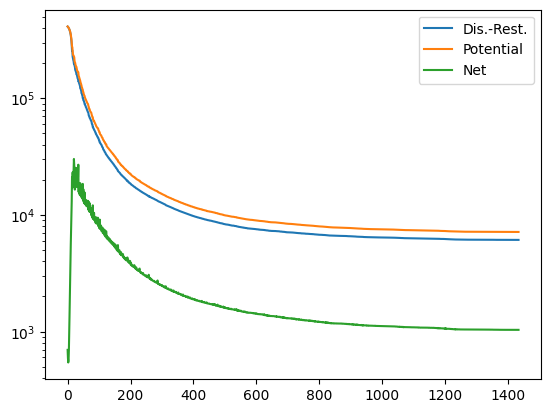

In [45]:
import matplotlib.pyplot as plt
energ = np.loadtxt('min.xvg',comments=['#','@'])
plt.plot(energ[:,1],label='Dis.-Rest.')
plt.plot(energ[:,2],label='Potential')
plt.plot(energ[:,2]-energ[:,1],label='Net')
plt.yscale('log')
plt.legend()
plt.show()
